# Model Structure

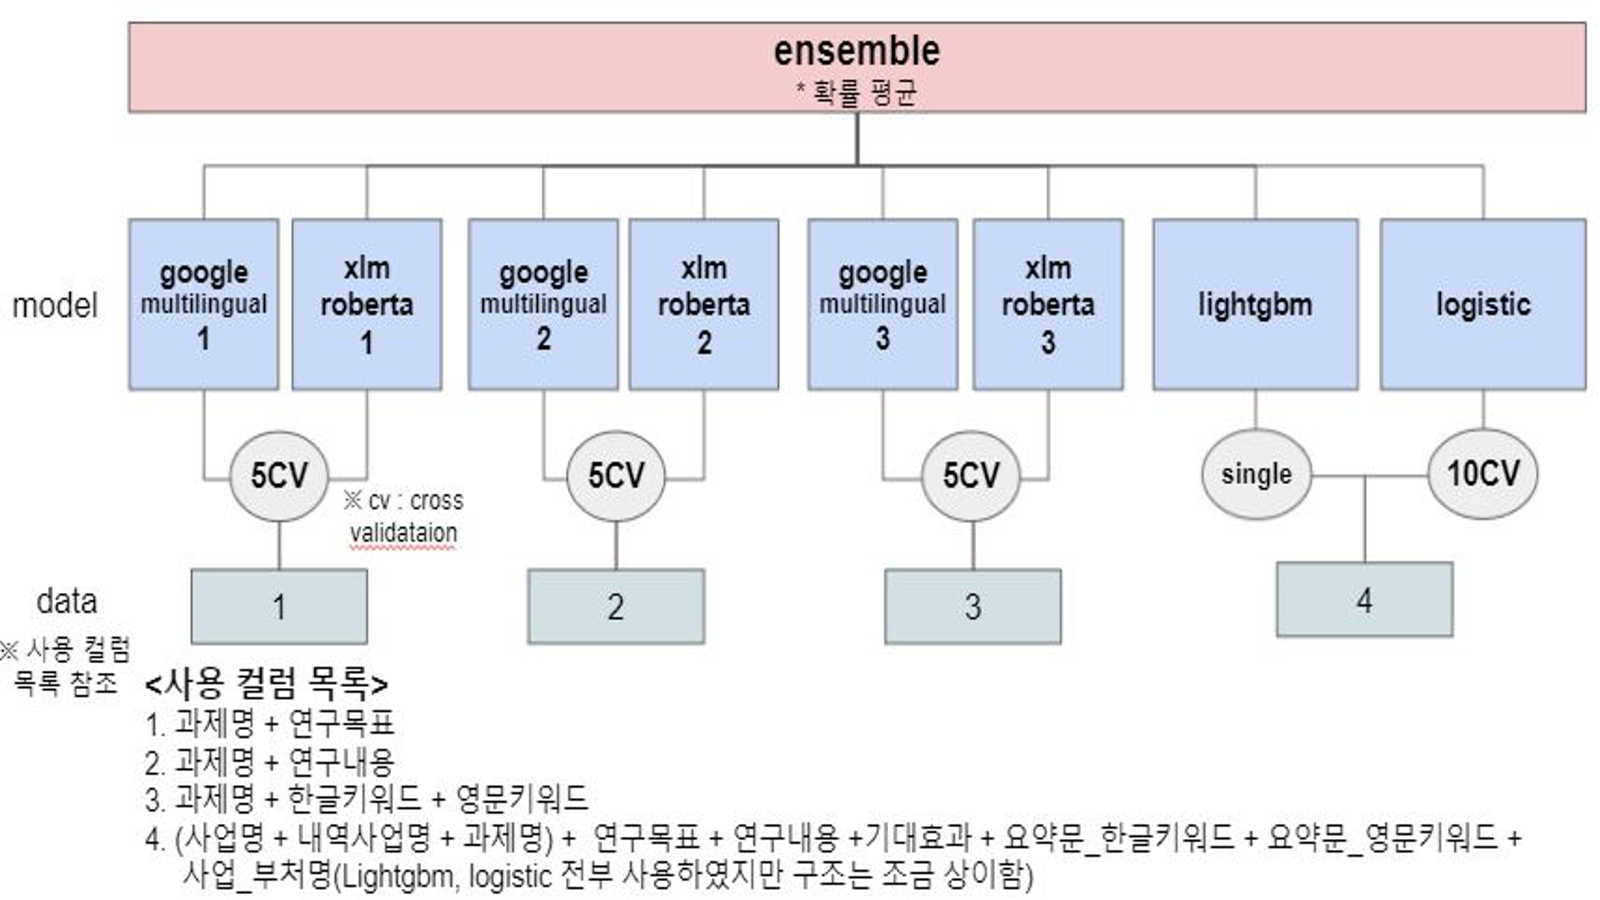

In [1]:
from PIL import Image
img = Image.open('../structure.JPG')
img.resize((1600,900))

# Dacon 기후기술분류

## 0. Intro
데이터를 처음 봤을 때 여러 컬럼에 다양한 형태들의 텍스트들이 존재하여 Language Model(BERT 등), Distributional Hypothesis(word2vec + CNN or LSTM), Bag-of-Words 방법(TF-IDF + ML방법) 모두 활용을 해봐야한다고 생각했습니다.  

많은 모델을 만들었지만 결론적으로 BILSTM, CNN, DNN은 큰 성과를 못내어 앙상블 시 제외하였습니다.  

또한 대회 중반까지 방향성을 잡지 못해 다른 Pretrained Language Model들을 적용하거나 파라미터 최적화와 Cross Validation을 끝까지 못하고 성능을 냈습니다.  


## 1. 전처리 
특수문자 제거나 결측값 채우는 정도의 선에서만 전처리를 하고, 키워드 부분은 따로 전처리를 하지 않았습니다. '과제명', '연구내용', '연구목표'만을 Mecab으로 형태소 분석하였습니다. 


## 2. Feature 선정
- Logistic CLS: 대부분의 column을 사용하였고 한 column으로 이어서 붙이지 않고 각 column들을 log-TF-IDF로 적용 후 학습 전에 concatenate 하였습니다. 그리고 각 column별로 모든 Feature들을 사용했습니다.(max_features에 따로 값을 주지않음) 또한 형태소 분석시 명사(mecab.nouns)만을 활용하였고 영문 키워드 같은 경우 nltk를 이용해 stemming만 하였습니다.   

- LightGBM : Logistic과 같이 명사를 추출한 것 까지는 동일하나 추출후 각 column들을 이어 붙여 log-TF-IDF를 적용후 SelectBestK를 이용하여 15000개 Feature 수를 추출하여 모델링을 하였습니다. 

- Google BERT, XLM-Roberta : Mecab.morphs를 적용 후 '과제명' + '연구목표', '과제명' + '연구내용', '과제명' + '한글키워드' + '영문키워드' 총 3가지 형태의 input을 구성하였습니다. '기대효과'는 validation 기준으로 성능이 제일 낮았었고, 앙상블 했을 때에도 성능이 떨어졌기 때문에 제외하였습니다. 


## 3. 사용 모델   
1, 2 과정을 적용 후 다음과 같은 모델을 만든 후 앙상블 했을 때 제일 좋은 점수를 얻었습니다.  
1. xlm-roberta(5fold cv, 모델 수 3(input) * 5(fold) = 15)  
2. bert-base-multilingual-cased(5fold cv, 모델 수 3(input) * 5(fold) = 15)  
3. Logistic(10fold cv, 모델 수 1(input) * 10(fold) = 10)  
4. LightGBM(단일 모델, 모델 수 1)

## 4. Ensemble
각 모델별로 cv 한 모델들의 로짓들을 평균낸 후 앙상블 했습니다. 여러 앙상블방법들을 적용했을 때 성능차이가 서로 거의 없었으나 TREX99님 앙상블 함수를 적용하였을때 근소하게 제일 좋았습니다. 

## 5. code
추후 업로드 예정

## 6. Share Ideas
여러 실험을 했던 내용들을 공유합니다. 
- 저희가 전처리 한 것을 기준으로 한국어 PLM모델보다 multilingual PLM모델들이 validation set 기준으로 성능이 좋았습니다. 따라서 구글 bert-base-multilingual-cased 를 기준으로 성능을 최대한 올리고자 하였습니다.  
- NaN이랑 non NaN 라벨을 먼저 나누고 계층적으로 모델을 접근하고자 하였으나 처음부터 non NaN을 잘못 예측하면 노이즈가 중첩된다고 판단하여 포기하였습니다.  
- 대회 초반에 loss를 다른 것(Self-adjusting Dice Loss, Focal Loss)을 써서 적용을 했을 때 성능이 좋지 않았는데 대회 막바지에 시간이 없어 적용을 해보지는 않았습니다. 
- 데이터가 상당히 imbalance 하지만 프로젝트를 해보면서 오버샘플링해서 좋았던 기억이 없었기 때문에 따로 리샘플링 기법들을 활용하지 않았습니다.  
- PLM쪽 Max lengths가 길어졌을 때 오히려 성능이 떨어지는 현상이 있었습니다.
- NaN으로 잘못 예측한 건들에서 많이 등장하는 키워드를 분석결과 한글&영문키워드 column에서 해당 키워드들이 많이 등장함을 확인했습니다. 해당 컬럼을 input으로 하는 모델 추가 후 성능이 향상되었습니다.  
- 최종적으로 활용한 plm모델은 google_multilngual & xlm_roberta_large 두가지였는데, 개별 모델 성능(valid set 기준)은 비슷했으나, Ensemble 했을때 Total 성능이 향상되었습니다.
- BERT Classification의 경우 경험상 3~5 epoch 내에 optimal한 loss에 수렴하였으나, 금번 모델의 경우 최소 10epoch 이상 학습시켜야 optimal한 loss에 수렴하였습니다.

# Contents
(참고)챕터별로 메모리를 관리를 하시는 것이 좋습니다. 
1. Make Train data & 전처리
2. Train model (CV 5-fold)
    - choose Best model(by epoch)
3. Lightgbm  
4. Logistic 
5. Ensemble

## GPU 확인 및 패키지 불러오기

In [ ]:
!nvidia-smi

In [ ]:
## 사용할 gpu 선정
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
## transformer & torch 버전 확인
import transformers
import torch
print(transformers.__version__, torch.__version__,  )

In [1]:
import sys
import time
import os
import re
import glob
import json
import joblib
import pickle
import pandas as pd
pd.set_option('mode.chained_assignment',  None)
import numpy as np
import random
import itertools
import logging
from logging.handlers import RotatingFileHandler
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import f1_score

tqdm.pandas()
import matplotlib.pyplot as plt

# bert
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from transformers import XLMRobertaConfig, XLMRobertaTokenizer, XLMRobertaTokenizerFast, XLMRobertaModel, XLMRobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

from torch.nn import CrossEntropyLoss

# ml
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, f1_score, recall_score, precision_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pickle
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from scipy.sparse import hstack

from sklearn.linear_model import LogisticRegression


import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance
from bayes_opt import BayesianOptimization
from scipy.stats.mstats import gmean

from konlpy.tag import Mecab
mecab = Mecab()

C:\Users\82102\anaconda3\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'lightgbm'

# 1. Make Train data & 전처리

In [ ]:
## data 확인
data_dir = f'../data/og_tb/'
print(os.listdir(data_dir))

In [ ]:
og_total = pd.read_csv(data_dir + 'train.csv')
og_test = pd.read_csv(data_dir + 'test.csv')
mapping = pd.read_csv(data_dir + 'labels_mapping.csv')
sample_sub = pd.read_csv(data_dir + 'sample_submission.csv')

In [2]:
og_total = pd.read_csv('train.csv')
og_test = pd.read_csv('test.csv')
mapping = pd.read_csv('labels_mapping.csv')
sample_sub = pd.read_csv('sample_submission.csv')

In [3]:
og_total.head(3)

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드,label
0,0,2016,농업기초기반연구,농촌진흥청,신규,농산물안전성연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,○ 새로운 해충분류군의 동정기술 개발 및 유입확산 추적,(가) 외래 및 돌발해충의 발생조사 및 종 동정\n\n\n ○ 대상해충 : 최...,"○ 새로운 돌발 및 외래해충의 신속, 정확한 동정법 향상\n\n\n○ 돌발 및 외래...","뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체","nucleotide sequence, molecular marker, species...",24
1,1,2019,이공학학술연구기반구축(R&D),교육부,신규,지역대학우수과학자지원사업(1년~5년),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,최종목표: TRAIL 감수성 표적 유전자를 발굴하고 내성제어 기전을 연구. 발굴된...,1차년도\n1) Microarray를 통한 선천적 TRAIL 내성 표적 후보 유전자...,"1) TRAIL 내성 특이적 표적분자를 발굴하고, 이를 이용한 TRAIL 효과 증진...","대장암,항암제 내성,세포사멸,유전자발굴","TRAIL,Colorectal cancer,TRAIL resistance,Apopt...",0
2,2,2016,중소기업기술혁신개발,중소기업청,신규,혁신기업기술개발,비목질계 셀룰로오스 식물자원을 활용한 기능성 부직포 및 고부가가치 뷰티케어 faci...,* 식물계자원 정련 및 최적 신서란 파이버 기초연구 개발\n\n\n* 소비자 및 바...,* 식물계자원 정련 및 최적 신서란 파이버 기초연구 개발\n\n\n- Tencel/...,* 국내 독자적인 비목질계 셀룰로오스 자원의 파이버 및 부직포 제조 등의 기술 확보...,"기능성 샐룰로오스 파이버,천연섬유,기능성 부직포,뷰티&amp;케어 제품,미용 솜","functional cellulose fiber,natural fiber,funct...",0


In [4]:
mapping.head(3)

,label,소분류
0,0,00. NaN
1,1,01. 원자력 발전
2,2,02. 핵융합 발전


### Data 전처리

In [5]:
## mapping dic 생성
mapping.index = mapping.label
mapping_dic = mapping.to_dict()['소분류']

In [7]:
mapping.head(3)

,label,소분류
label,,
0,0,00. NaN
1,1,01. 원자력 발전
2,2,02. 핵융합 발전


In [8]:
mapping_dic

{0: '00. NaN',
 1: '01. 원자력 발전',
 2: '02. 핵융합 발전',
 3: '03. 청정화력발전·효율화',
 4: '04. 수력',
 5: '05. 태양광',
 6: '06. 태양열',
 7: '07. 지열',
 8: '08. 풍력',
 9: '09. 해양에너지',
 10: '10. 바이오에너지',
 11: '11. 폐기물',
 12: '12. 수소 제조',
 13: '13. 연료전지',
 14: '14. 전력 저장',
 15: '15. 수소 저장',
 16: '16. 송배전 시스템',
 17: '17. 전기 지능화 기기',
 18: '18. 수송 효율화',
 19: '19. 산업 효율화',
 20: '20. 건축 효율화',
 21: '21. CCUS',
 22: '22. Non-CO2저감 ',
 23: '23. 유전자원·유전개량',
 24: '24. 작물재배·생산',
 25: '25. 가축 질병관리',
 26: '26. 가공·저장·유통',
 27: '27. 수계·수생태계',
 28: '28. 수자원 확보 및 공급',
 29: '29. 수처리',
 30: '30. 수재해 관리',
 31: '31. 기후 예측 및 모델링',
 32: '32. 기후 정보 경보 시스템',
 33: '33. 해양생태계',
 34: '34. 수산자원',
 35: '35. 연안 재해 관리',
 36: '36. 감염 질병 관리',
 37: '37. 식품 안전 예방',
 38: '38. 산림 생산 증진',
 39: '39. 산림피해저감',
 40: '40. 생태·모니터링·복원',
 41: '41. 신재생에너지 하이브리드',
 42: '42. 저전력 소모 장비',
 43: '43. 에너지 하베스팅',
 44: '44. 인공광합성',
 45: '45. 기타 기후변화 관련 기술'}

In [9]:
## label idx 달아주기
og_total.loc[:, 'label_nm'] = [mapping_dic[n] for n in og_total.label.tolist()]
print(og_total.shape)
og_total.head(2)

(174304, 14)


,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드,label,label_nm
0,0,2016,농업기초기반연구,농촌진흥청,신규,농산물안전성연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,○ 새로운 해충분류군의 동정기술 개발 및 유입확산 추적,(가) 외래 및 돌발해충의 발생조사 및 종 동정\n\n\n ○ 대상해충 : 최...,"○ 새로운 돌발 및 외래해충의 신속, 정확한 동정법 향상\n\n\n○ 돌발 및 외래...","뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체","nucleotide sequence, molecular marker, species...",24,24. 작물재배·생산
1,1,2019,이공학학술연구기반구축(R&D),교육부,신규,지역대학우수과학자지원사업(1년~5년),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,최종목표: TRAIL 감수성 표적 유전자를 발굴하고 내성제어 기전을 연구. 발굴된...,1차년도\n1) Microarray를 통한 선천적 TRAIL 내성 표적 후보 유전자...,"1) TRAIL 내성 특이적 표적분자를 발굴하고, 이를 이용한 TRAIL 효과 증진...","대장암,항암제 내성,세포사멸,유전자발굴","TRAIL,Colorectal cancer,TRAIL resistance,Apopt...",0,00. NaN


In [ ]:
# ## NAN값 변경
# og_total = og_total.fillna("None")
# og_test = og_test.fillna("None")

### Text 전처리

1. Mecab을 통한 형태소 분석 결과 append
2. 필요 Column merge 후 최종 Text 생성

In [ ]:
total = og_total.copy()
test = og_test.copy()

# ## 임시
# total = total.loc[:999,:].copy()
# test = test.loc[:999,:].copy()

In [ ]:
def make_preprocessed_data(data, mode):
    data['요약문_연구목표'] = data['요약문_연구목표'].fillna(' ')
    data['요약문_연구내용'] = data['요약문_연구내용'].fillna(' ')
    data['요약문_기대효과'] = data['요약문_기대효과'].fillna(' ')
    data['요약문_한글키워드'] = data['요약문_한글키워드'].fillna(' ')
    data['요약문_영문키워드'] = data['요약문_영문키워드'].fillna(' ')
    data['사업명조합'] = data['사업명'] + ' ' + data['내역사업명'] + ' ' + data['과제명']
    # 비슷한 것 끼리 합친 느낌?
    
    data['요약문_영문키워드'] = data['요약문_영문키워드'].str.lower()
    data['요약문_연구내용'] = data['요약문_연구내용'].str.lower()
    data['요약문_기대효과'] = data['요약문_기대효과'].str.lower()
    data['요약문_연구목표'] = data['요약문_연구목표'].str.lower()
    data['사업명조합'] = data['사업명조합'].str.lower()
    # 전부다 소문자로 바꿔주고
    
    data['요약문_한글키워드']=data['요약문_한글키워드'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》●○#-]', ' ')
    data['요약문_영문키워드']=data['요약문_영문키워드'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》●○#-]', ' ')
    data['요약문_연구목표']=data['요약문_연구목표'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》●○#-]', ' ')
    data['요약문_연구내용']=data['요약문_연구내용'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》●○#-]', ' ')
    data['요약문_기대효과']=data['요약문_기대효과'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》●○#-]', ' ')
    data['사업명조합']=data['사업명조합'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》●○#-]', ' ')
    # 이상한 문자들 다 없애주고
    
    data['요약문_기대효과']=data['요약문_기대효과'].str.replace('\n', ' ')
    data['요약문_한글키워드']=data['요약문_한글키워드'].str.replace(',', ' ')
    data['요약문_영문키워드']=data['요약문_영문키워드'].str.replace(',', ' ')
    # data['요약문_연구목표']=data['요약문_연구목표'].str.replace(r'[0-9]', 'num')
    data['요약문_연구목표']=data['요약문_연구목표'].str.replace('\n', ' ')
    # data['요약문_연구내용']=data['요약문_연구내용'].str.replace(r'[0-9]', 'num')
    data['요약문_연구내용']=data['요약문_연구내용'].str.replace('\n', ' ')
    
    
    # 이 밑에 코드는 문장들을 전부 형태소로 나누고 합치는 단계입니다.
    # mecab.morphs : 입력된 문장을 모든 형태소 단위로 나눕니다.
    # mecab.nouns : 명사만 추출합니다.
    if mode == 'morphs':
        data_morphs_combination = []
        data_morphs_goal = []
        data_morphs_contents = []
        data_morphs_expect = []
        
        for i in tqdm(range(len(data))):
            tmp1_txt = mecab.morphs(data.iloc[i]['사업명조합'])
            tmp2_txt = mecab.morphs(data.iloc[i]['요약문_연구목표'])
            tmp3_txt = mecab.morphs(data.iloc[i]['요약문_연구내용'])
            tmp4_txt = mecab.morphs(data.iloc[i]['요약문_기대효과'])

            data_morphs_combination.append(' '.join(tmp1_txt))
            data_morphs_goal.append(' '.join(tmp2_txt))
            data_morphs_contents.append(' '.join(tmp3_txt))
            data_morphs_expect.append(' '.join(tmp4_txt))
        
        data['morphs_combination'] = data_morphs_combination
        data['morphs_goal'] = data_morphs_goal
        data['morphs_contents'] = data_morphs_contents
        data['morphs_expect'] = data_morphs_expect
        
    elif mode == 'nouns':
        data_nouns_combination = []
        data_nouns_goal = []
        data_nouns_contents = []
        data_nouns_expect = []
        
        for i in tqdm(range(len(data))):
            tmp1_txt = mecab.nouns(data.iloc[i]['사업명조합'])
            tmp2_txt = mecab.nouns(data.iloc[i]['요약문_연구목표'])
            tmp3_txt = mecab.nouns(data.iloc[i]['요약문_연구내용'])
            tmp4_txt = mecab.nouns(data.iloc[i]['요약문_기대효과'])

            data_nouns_combination.append(' '.join(tmp1_txt))
            data_nouns_goal.append(' '.join(tmp2_txt))
            data_nouns_contents.append(' '.join(tmp3_txt))
            data_nouns_expect.append(' '.join(tmp4_txt))
        
        data['nouns_combination'] = data_nouns_combination
        data['nouns_goal'] = data_nouns_goal
        data['nouns_contents'] = data_nouns_contents
        data['nouns_expect'] = data_nouns_expect
        
    else:
        raise print('Please Choose morphs or nouns!')
        
    return data

### PLM 및 ML용 형태소 분석
PLM에 활용할 데이터는 morphs, ML에 활용할 데이터는 Nouns만 적용 후 데이터 저장  
환경에 따라 소요시간이 차이가 남(대략 형태소 분석만 30분 소요됨)

In [ ]:
mecab_morph_dir = '../data/mecab_data/'
mph_train_tb = make_preprocessed_data(total, 'morphs') 
mph_test_tb = make_preprocessed_data(test, 'morphs') 
torch.save(mph_train_tb, mecab_morph_dir + '/morphs_preprocessed_morphs_trn.torch')
torch.save(mph_test_tb, mecab_morph_dir + '/morphs_preprocessed_morphs_tst.torch')

In [ ]:
trn = make_preprocessed_data(total, 'nouns')
tst = make_preprocessed_data(test, 'nouns')
torch.save(trn, mecab_morph_dir + '/nouns_preprocessed_trn.torch')
torch.save(tst, mecab_morph_dir + '/nouns_preprocessed_tst.torch')

In [ ]:
# for memory
del total, test

In [ ]:
## Mecab 형태소 분석 결과 append

# combination: 사업명조합 (data['사업명'] + ' ' + data['내역사업명'] + ' ' + data['과제명'])
# goal : 연구목표
# contents : 연구내용
# expect : 기대효과

mecab_morph_dir = '../data/mecab_data/' 
os.listdir(mecab_morph_dir)

## 파일 불러오기
mph_train_tb = torch.load(mecab_morph_dir + '/morphs_preprocessed_morphs_trn.torch')
mph_test_tb = torch.load(mecab_morph_dir + '/morphs_preprocessed_morphs_tst.torch')

# nouns

## col merge
text_col_lst = ['morphs_goal', 'morphs_contents']
save_col_lst = ['연구목표_morph', '연구내용_morph']


for i in range(len(text_col_lst)):
    col = text_col_lst[i]
    save_col = save_col_lst[i]
    print('\n\n', col, save_col)
    
    ## 길이가 1 이상인 것들 모두 사용
    final_train_mph = [[m for m in n.split(" ") if len(m)>=1] for n in mph_train_tb[col].tolist()]
    final_test_mph = [[m for m in n.split(" ") if len(m)>=1] for n in mph_test_tb[col].tolist()]    
    print(len(final_train_mph), len(final_test_mph))

    ## 한개도 없으면 NONE 기입
    final_train_mph = [['None'] if len(n)==0 else n for n in final_train_mph]
    final_test_mph = [['None'] if len(n)==0 else n for n in final_test_mph]

#     ## 저장
    total.loc[:,f'{save_col}_mecab'] = ['키워드: ' + " ".join(n) for n in final_train_mph]
    test.loc[:,f'{save_col}_mecab'] = ['키워드: ' + " ".join(n) for n in final_test_mph]

In [ ]:
## 한글, 영문 키워드 공백 만들어주기
total.loc[:,f'한글영문키워드_전처리후'] = [n[0].replace(","," ") + " / " + n[1].replace(","," ") for n in total[['요약문_한글키워드', '요약문_영문키워드']].values]
test.loc[:,f'한글영문키워드_전처리후'] = [n[0].replace(","," ") + " / " + n[1].replace(","," ") for n in test[['요약문_한글키워드', '요약문_영문키워드']].values]

### Text merge
- BERT 사용 Text col
    - 연구목표, 연구내용, 한글영문키워드

In [ ]:
total.loc[:,'과제명_연구목표_morph_mecab'] = [" . / ".join(n) for n in total[['과제명', '연구목표_morph_mecab']].values]
total.loc[:,'과제명_연구내용_morph_mecab'] = [" . / ".join(n) for n in total[['과제명', '연구내용_morph_mecab']].values]
total.loc[:,'과제명_한글영문키워드_전처리후'] = [" . / ".join(n) for n in total[['과제명', '한글영문키워드_전처리후']].values]

test.loc[:,'과제명_연구목표_morph_mecab'] = [" . / ".join(n) for n in test[['과제명', '연구목표_morph_mecab']].values]
test.loc[:,'과제명_연구내용_morph_mecab'] = [" . / ".join(n) for n in test[['과제명', '연구내용_morph_mecab']].values]
test.loc[:,'과제명_한글영문키워드_전처리후'] = [" . / ".join(n) for n in test[['과제명', '한글영문키워드_전처리후']].values]

# 2. Train BERT model (CV 5-fold)


### CV index 나누기

In [ ]:
seed = 4321
cv_fold_cnt = 5

In [ ]:
skf = StratifiedKFold(n_splits=cv_fold_cnt, random_state=seed, shuffle=True)
total.loc[:,'fold'] = -1

for n_fold, (_,v_idx) in enumerate(skf.split(total, total['label_nm'])):
    total.loc[v_idx, 'fold'] = n_fold
    
total.loc[:,'id'] = [n for n in range(len(total))]
total.fold.value_counts()

## Train BERT model & Make Pred Table
- 활용한 `BERT model`은 2가지
    - google, xlm-roberta
- 활용한 `Text col`은 3가지
    - 과제명&연구목표, 과제명&연구내용, 과제명&한글영문키워드        

In [ ]:
## 학습에 필요한 함수 import
sys.path.append(f'../src/')
from bert import *

## label dict 생성
model_args = {"label":list(mapping_dic.values())}

In [ ]:
## 돌린 날짜 생성
today = datetime.today().strftime('%Y%m%d')

train_model_lst = ['google', 'xlm-roberta']
train_text_col_lst = ['과제명_연구목표_morph_mecab', '과제명_연구내용_morph_mecab', '과제명_한글영문키워드_전처리후']

model_text_tuple = list(itertools.product(train_model_lst, train_text_col_lst))

## 한번에 다 돌리면 메모리 에러가 날 가능성 있음, TASK별로 나눠서 돌리는걸 권장함
model_text_tuple

In [ ]:
## Train Start
## 모든 TASK를 한번에 다 돌리면 메모리 에러가 날 수 있음, TASK별로 나눠서 돌리는걸 권장함
for task in model_text_tuple:
    print(task)
    bert_nm = task[0]
    text_col = task[1]
    
    # ----------------------------------------------------- 1. Train Start -----------------------------------------------------
    ## Train args 설정
    args = {'bert_nm': bert_nm,
            'task_nm': 'weather_data_cls_total',
            'model_nm': '46cls_total',
            'output_dir': "NONE", ## 일단 None으로 기입
            
            'train_batch_size': 32,
            'eval_batch_size': 32,
            'pred_batch_size':256,
            'max_seq_length': 64,
            'learning_rate': 2e-05,
            'num_train_epochs': 20,

            'warmup_proportion': 0.1,
            'seed': seed,
            'gradient_accumulation_steps': 1,
            'no_cuda': False,
            'n_gpu': 1,
            'scheduler': True,
            'output_attentions':False,

            'index_col': 'index',
            'label_col': 'label_nm',
            'text_col': text_col}

    ## model 성능,경로 기록용 dic 생성
    best_cv_model_dic = {}
    base_dir = f"../result/bert_result/{today}/{args['task_nm'].replace('_','')}_model{args['bert_nm']}_e{args['num_train_epochs']}_txt{text_col.replace('_','')}_lr{str(args['learning_rate']).replace('.','')}_m{args['max_seq_length']}"

    ## log file setting 
    logger = make_logfile(base_dir, args)

    ## CV fold Start
    for fold in range(cv_fold_cnt):
        print(f'--------------------------------------------- fold:{fold} result ---------------------------------------------')
        logger.info(f'--------------------------------------------- fold:{fold} result ---------------------------------------------')
        ## CV 데이터 split
        train = total[total.fold != fold].reset_index(drop=True)
        valid = total[total.fold == fold].reset_index(drop=True)

        ## --------------------------------------------------------- save_dir setting ---------------------------------------------------------     
        output_dir = os.path.join(base_dir, f'fold_{fold}/')
        os.makedirs(output_dir, exist_ok=True)
        print(output_dir)
        args['output_dir'] = output_dir

        ## --------------------------------------------------------- seed & env setting --------------------------------------------------------- 
        set_seed(args['seed'])

        logger.info(f"Label list: {model_args['label']}")
        logger.info(f"Label to ID: {get_label2id(model_args['label'])}")

        # Setup GPU parameters
#             args, device = set_env(args)
        full_gpu = True
        device = torch.device("cuda" if torch.cuda.is_available() and not args["no_cuda"] else "cpu")
        if full_gpu:
            args['n_gpu'] = torch.cuda.device_count()
        logger.info("device: {} n_gpu: {}".format(device, args['n_gpu']))        
        args['train_batch_size'] = int(args['train_batch_size'] / args['gradient_accumulation_steps'])

        ## --------------------------------------------------------- model & tokenizer setting --------------------------------------------------------- 
        print(f'>>> pre_train model import ....')
        logger.info(f'>>> pre_train import ....')

        tokenizer, bert_config, model = import_model(args, model_args, logger)
        model.to(device)

        ## --------------------------------------------------------- data pre-processing --------------------------------------------------------- 
        train_df, train_examples = create_examples(train, args, set_type = 'train', logger = logger)
        valid_df, valid_examples = create_examples(valid, args, set_type = 'valid', logger = logger)

        num_train_steps = int(len(train_examples) / args['train_batch_size'] / args['gradient_accumulation_steps'] * args['num_train_epochs'])

        ## Final Table 확인
        label_col = args['label_col']
        print(train_df.shape, valid_df.shape)
        display(train_examples[0].__dict__)

        ### tokenizer를 통해 실제 들어가는 텍스트 확인
        temp = [tokenizer.decode(tokenizer.encode(n)[:args['max_seq_length']]) for n in train_df[args['text_col']].values[0:10]]
        display(temp)
        logger.info(temp)

        logger.info('ex to fea...')
        train_features = examples_to_features(train_examples, args['max_seq_length'], tokenizer,  get_label2id(model_args['label']), logger)
        valid_features = examples_to_features(valid_examples, args['max_seq_length'], tokenizer, get_label2id(model_args['label']), logger)

        logger.info('fea to loader...')
        train_dataloader = feature_to_loader(train_features, batch_size = args['train_batch_size'], mode = 'train')
        valid_dataloader = feature_to_loader(valid_features, batch_size = args['train_batch_size'], mode = 'eval')

        logger.info("Train Valid Splitted") 
        logger.info("Trainset size: {}  &  Validset size: {}".format(len(train_features), len(valid_features)))


        ## --------------------------------------------------------- setting optimizer & scheduler --------------------------------------------------------- 
        logger.info('opt setting...')
        logger.info(f"scheduler: {args['scheduler']} setting...")

        t_total = len(train_dataloader) * args['num_train_epochs']
        warmup_step = int(t_total * args['warmup_proportion'])
        print(t_total, warmup_step)

        optimizer, scheduler = set_optimizers_v1(model = model
                                              ,learning_rate = args['learning_rate'] 
                                              ,warmup_steps = warmup_step                                      
                                              ,num_training_steps = num_train_steps
                                              ,scheduler_yn = args['scheduler'])
        criterion = CrossEntropyLoss()

        ## --------------------------------------------------------- Train & Valid 진행 ---------------------------------------------------------
        tot_loss, tr_loss, global_step = 0, 0, 0
        loss_lst, lr_lst, valid_result = [], [], []
        metric_lst, model_lst = [], []
        for epoch in range(int(args['num_train_epochs'])):
            torch.cuda.empty_cache()
            model.train()

            model_name = f"finetuned_{args['bert_nm']}_classifier_pytorch_model_fold{fold}_m{args['max_seq_length']}_e{str(epoch).zfill(2)}.bin"
            logger.info("*****  Running evaluation  of {}  *****".format(model_name))

            log_step = 0

            epoch_iterator = tqdm(train_dataloader)
            for step, batch in enumerate(epoch_iterator):
                epoch_iterator.set_description('iteration:{} (loss: {})'.format(step, np.round(tot_loss,5)))
                batch = tuple(t.to(device) for t in batch)
                input_ids, input_mask, segment_ids, label_ids = batch
                if args['bert_nm'] == 'xlm-roberta':
                    output = model(input_ids = input_ids, 
                                   attention_mask = segment_ids, 
    #                              token_type_ids = input_mask, 
                                   labels = label_ids)
                else:
                    output = model(input_ids = input_ids, 
                                   attention_mask = segment_ids, 
                                   token_type_ids = input_mask, 
                                   labels = label_ids)

                _logits = output[1]
                _targets = label_ids.view(-1)
                loss = criterion(_logits, _targets)
                loss.backward()

                if args['n_gpu'] > 1:
                    loss = loss.mean() # mean() to average on multi-gpu.
                tr_loss += loss.item()

                torch.nn.utils.clip_grad_norm_(model.parameters(),1)
                optimizer.step()
                scheduler.step()
                model.zero_grad()
                global_step += 1
                tot_loss = tr_loss / (global_step+1)  

                ## log를 위해 추가
                log_step += 1
                if log_step%1500 == 0:
                    logger.info(f'######### Global Step: {global_step} / Epoch Step: {log_step} 진행중... ######### ')

            ## Valid 진행
            valid_acc, true, pred, prob_lst, confu_df, prf_df = evaluate_model_v1(model, device,
                                                                                  dataloader = valid_dataloader,
                                                                                  args = args,
                                                                                  model_args = model_args
                                                                                  )        
            guid_lst = [i.guid.split('-')[1].split('_') for i in valid_features]
            final_output = pd.DataFrame(guid_lst, columns = ['key'], dtype='int64')

            ## valid pred append
            final_output.loc[:,'pred'] = pred
            ## label cls별 확률값 저징
            for i in range(prob_lst.shape[1]):
                final_output.loc[:,f'pred_prob_{i}'] = prob_lst[:,i]

            ## 모델 성능평가 
            valid_result.append(valid_acc)
            macro_f1, micro_f1, weighted_f1 = f1_score(true, pred, average = 'macro'), f1_score(true, pred, average = 'micro'), f1_score(true, pred, average = 'weighted')
            print(f"\033[1m Macro f1: {macro_f1:.4f} / Micro f1: {micro_f1:.4f} / Weighted f1: {weighted_f1:.4f}\033[0m")
            logger.info('Epoch {} Validset acc: {}'.format(epoch, valid_acc))
            logger.info(f"Macro f1: {macro_f1:.4f} / Micro f1: {micro_f1:.4f} / Weighted f1: {weighted_f1:.4f}")

            ## save model
            model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
            output_model_file = os.path.join(output_dir, model_name)
            logger.info(f'Model Saved at {output_model_file}')
            torch.save(model_to_save.state_dict(), output_model_file)
            bert_config.save_pretrained(output_dir)        

            ## model metric save
            metric_lst.append(macro_f1)
            model_lst.append(output_model_file)

        ## choose best model(fold 별)
#         metric_lst = [n for n in range(args['num_train_epochs'])]                                         ##### -> 테스트용으로 임시로 넣어놓은코드, 최종 코드에는 삭제 필요
        best_idx = np.argmax(metric_lst)
        best_model_dir, best_model_score = model_lst[best_idx], metric_lst[best_idx]
        print(best_model_dir, best_model_score)
        logger.info(f'{best_model_dir} is the best model by validation score with {np.round(max(metric_lst),4)}\n\n')
        
        
        ## remove useless checkpoint
        model_topk = 2 ## 최종으로 남길 모델 수 선정
        model_lst = sorted([i for i in os.listdir(output_dir) if i[-3:]=='bin'])
#         best_model_dir_fordel = os.path.join(output_dir, model_lst[np.argmax(metric_lst)])
        trash_idx = sorted(range(len(metric_lst)), key = lambda sub: metric_lst[sub])[:int(args['num_train_epochs']-model_topk)] ## metric_lst 기준으로 삭제할 모델 idx 선정
        remove_lst = [os.path.join(output_dir, model_lst[idx]) for idx in trash_idx]
        for remove_dir in remove_lst:
            os.remove(remove_dir)
        logger.info('Useless checkpoint removed')

        ## append best model
        best_cv_model_dic[f'fold_{fold}_best_model'] = [best_idx, best_model_score, best_model_dir]

        ## save cv result    
        cv_result = pd.DataFrame.from_dict(best_cv_model_dic).transpose().reset_index()
        cv_result.columns = ['idx', 'epoch', 'macro_f1', 'model_dir']
        cv_result.to_csv("/".join(output_dir.split("/")[:-2]) + "/" + "cv_result.csv", index=False, encoding = 'utf-8-sig')
    
        print(f'--------------------------------------------- fold:{fold} result END --------------------------------------------- \n\n')
        logger.info(f'--------------------------------------------- fold:{fold} result END --------------------------------------------- \n\n')    

    # ------------------------------------------------------------- 2. Make Submission Data -------------------------------------------------------------

    logger.info(f'\n\n>>> Submission Data 생성')
    logger.info(best_cv_model_dic)
    display(cv_result)
    
    ## submission data 생성
    test_df, test_examples = create_examples(test, args, set_type = 'pred', logger = logger)
    test_features = examples_to_features(test_examples, args['max_seq_length'], tokenizer, get_label2id(model_args['label']), logger = logger)
    display(test_df[['과제명', text_col]].head(2))
    test_dataloader = feature_to_loader(test_features, batch_size = args['pred_batch_size'], mode = 'pred')

    ## CV fold 별로 submission file 생성
    for fold in range(cv_fold_cnt):
        print(f'--------------------------------------------- fold:{fold} Pred Start --------------------------------------------- \n\n')
        logger.info(f'--------------------------------------------- fold:{fold} Pred Start --------------------------------------------- \n\n')

        final_model_dir = best_cv_model_dic[f'fold_{fold}_best_model'][2]
        final_model_dir

        ## CV model setting
        model_dir = final_model_dir
        config_dir = "/".join(final_model_dir.split("/")[:-1])+"/"
        logger.info(f'>>> {model_dir} model import ...')
        bert_config, model = import_finetuned_model(args, model_args, model_dir, config_dir)
        model.to(device)

        logger.info("***** Running Prediction *****")

        layer_k = -1
        all_logits = None
        model.eval()
        for input_ids, input_mask, segment_ids in tqdm(test_dataloader):
            input_ids = input_ids.to(device)
            segment_ids = segment_ids.to(device)
            input_mask = input_mask.to(device)
            with torch.no_grad():
                if args['bert_nm'] == 'xlm-roberta':
                    output = model(input_ids = input_ids,
                                   attention_mask = segment_ids,
        #                          token_type_ids = input_mask
                                   )
                else:
                    output = model(input_ids = input_ids,
                                   attention_mask = segment_ids, 
                                   token_type_ids = input_mask
                                   )
                logit = output[0]

            if all_logits is None:
                all_logits = logit.detach().cpu()
            else:
                all_logits = np.concatenate((all_logits, logit.detach().cpu()), axis=0)

        softmax = torch.nn.Softmax(dim = 1)
        prob_lst = softmax(torch.tensor(all_logits)).numpy()
        pred_lst = np.argmax(prob_lst, axis  = 1)
        pred_prob = np.max(prob_lst, axis  = 1) 

        ## final output 생성
        guid_lst = [i.guid.split('-')[1].split('_') for i in test_features]
        final_output = pd.DataFrame(guid_lst, columns = ['key'], dtype='int64')

        final_output['pred'] = [get_id2label(model_args['label'])[i] for i in pred_lst]
        final_output['pred_id'] = pred_lst
        final_output['pred_prob_top'] = pred_prob
        ## label cls별 확률값 저징
        for i in range(prob_lst.shape[1]):
            final_output.loc[:,f'pred_prob_{i}'] = prob_lst[:,i]

        ## Test set과 append
        final_output = pd.concat([test_df, final_output], axis=1)

        submission_file = pd.DataFrame()
        submission_file.loc[:, 'key'] = test['index'].copy()
        submission_file.loc[:,'final_pred_id'] = [get_label2id(model_args['label'])[n] for n in final_output.pred.values]

        final_sub_file = submission_file[['key', 'final_pred_id']]
        final_sub_file.columns = ['index', 'label']

        ## save submission file
        cv_output_dir = f"../pred_tb/bert_result/"
        os.makedirs(cv_output_dir, exist_ok=True)

        pred_save_nm = f"{args['bert_nm'].replace('_','')}_{args['text_col'].replace('_','')}_fold{fold}_total_tb_onlypred.csv"

        final_output[[#'key', 'pred', 'pred_id', 'pred_prob_top',
                         'pred_prob_0', 'pred_prob_1', 'pred_prob_2', 'pred_prob_3',
                         'pred_prob_4', 'pred_prob_5', 'pred_prob_6', 'pred_prob_7',
                         'pred_prob_8', 'pred_prob_9', 'pred_prob_10', 'pred_prob_11',
                         'pred_prob_12', 'pred_prob_13', 'pred_prob_14', 'pred_prob_15',
                         'pred_prob_16', 'pred_prob_17', 'pred_prob_18', 'pred_prob_19',
                         'pred_prob_20', 'pred_prob_21', 'pred_prob_22', 'pred_prob_23',
                         'pred_prob_24', 'pred_prob_25', 'pred_prob_26', 'pred_prob_27',
                         'pred_prob_28', 'pred_prob_29', 'pred_prob_30', 'pred_prob_31',
                         'pred_prob_32', 'pred_prob_33', 'pred_prob_34', 'pred_prob_35',
                         'pred_prob_36', 'pred_prob_37', 'pred_prob_38', 'pred_prob_39',
                         'pred_prob_40', 'pred_prob_41', 'pred_prob_42', 'pred_prob_43',
                         'pred_prob_44', 'pred_prob_45']].to_csv(cv_output_dir + pred_save_nm
                         ,index = False, encoding = 'utf-8-sig')

        print(f'--------------------------------------------- fold:{fold} Pred END --------------------------------------------- \n\n')
        logger.info(f'--------------------------------------------- fold:{fold} Pred END --------------------------------------------- \n\n')

# 3. lightgbm

In [ ]:
or_data_dir = '../data/og_tb'
for_train_dir = '../data/for_train' 
src_ml_dir = '../feature_ml/ml_out' # label encoder, feature selector, vectorizer가 저장되는 경로
model_dir = '../result/lgbm_result'
pred_dir = '../pred_tb'

In [ ]:
trn = torch.load(mecab_morph_dir + 'nouns_preprocessed_trn.torch')
tst = torch.load(mecab_morph_dir +  'nouns_preprocessed_tst.torch')

train = pd.read_csv(os.path.join(or_data_dir,"train.csv"))
test = pd.read_csv(os.path.join(or_data_dir, "test.csv"))
sample_submission=pd.read_csv(os.path.join(or_data_dir, "sample_submission.csv"))

In [ ]:
trn['text'] = trn['nouns_combination'] + " " + trn['nouns_goal'] + " "  + trn['nouns_contents'] +trn['nouns_expect'] + " " + trn['요약문_한글키워드'] + " " + trn["요약문_영문키워드"]
tst['text'] =tst['nouns_combination'] + " " + tst['nouns_goal'] + " "  + tst['nouns_contents'] + tst['nouns_expect'] + " " + tst['요약문_한글키워드'] + " " + tst["요약문_영문키워드"]

In [ ]:
train_y= trn['label']

### Tfidfvectorizer, Selector 사용
1. 사업명 + 내역사업명 + 과제명
2. 연구목표 
3. 연구내용
4. 기대효과
5. 요약문_한글키워드
6. 요약문_영문키워드

In [ ]:
def make_feature(trn_text, train_y, tst_text,  top_k):
    vectorizer = TfidfVectorizer(sublinear_tf = True, min_df=4)
    train_features=vectorizer.fit_transform(trn_text)
    with open(os.path.join(src_ml_dir, 'lgbm_vectorizer.pkl'), 'wb') as f:
        pickle.dump(vectorizer, f)
    test_features=vectorizer.transform(tst_text)
    vector_name = vectorizer.get_feature_names()
    
    selector = SelectKBest(f_classif, k=min(top_k, train_features.shape[1]))
    train_features_s = selector.fit_transform(train_features, train_y)
    with open(os.path.join(src_ml_dir, 'lgbm_selector.pkl'), 'wb') as f:
        pickle.dump(selector, f)
    test_features_s = selector.transform(test_features)
    sel_vector_name = [vector_name[x] for x in selector.get_support(indices=True)]
    
    return train_features_s, test_features_s, sel_vector_name

In [ ]:
train_features_s, test_features_s, sel_vector_name = make_feature(trn['text'],train_y,tst['text'],15000)

### 사업_부처명 추가  
사업_부처명 nunique 수가 상대적으로 적고 라벨과 관련있다고 판단하여 추가하여 학습 진행함

In [ ]:
def make_label_feature(trn_text, tst_text) :
    lab = LabelEncoder()
    lab.fit(trn_text)
    with open(os.path.join(src_ml_dir, 'lgbm_labelencoder.pkl'), 'wb') as f:
        pickle.dump(lab, f)
    trn_label = lab.transform(trn_text)
    tst_label = lab.transform(tst_text)

    trn_label = csr_matrix(trn_label.reshape(-1,1))
    tst_label = csr_matrix(tst_label.reshape(-1,1))
    
    return trn_label, tst_label

In [ ]:
trn_label, tst_label = make_label_feature(train['사업_부처명'], test['사업_부처명'])

### Final input 구성
사용한 변수 : 
1. 사업명 + 내역사업명 + 과제명
2. 연구목표 
3. 연구내용
4. 기대효과
5. 요약문_한글키워드
6. 요약문_영문키워드
7. 사업_부처명

- 1-4는 mecab을 사용하여 명사만 추출 후, 6가지를 이어붙여서 15000개의 feature 사용
- 7번 추가로 붙여서 사용
- 총 15001 개의 feature 사용

In [ ]:
train_features = hstack([train_features_s, trn_label])
test_features = hstack([test_features_s, tst_label])

In [ ]:
torch.save(train_features, os.path.join(for_train_dir ,'lgbm_train_features.torch'), pickle_protocol = 4)
torch.save(test_features, os.path.join(for_train_dir, 'lgbm_test_features.torch'), pickle_protocol = 4)

In [ ]:
train_features = torch.load(os.path.join(for_train_dir ,'lgbm_train_features.torch'))
test_features = torch.load(os.path.join(for_train_dir, 'lgbm_test_features.torch'))

In [ ]:
train_features = train_features.astype('float64').tocsr()
train_features

In [ ]:
test_features = test_features.astype('float64').tocsr()
test_features

# **모델링**

In [ ]:
import gc
gc.collect()

In [ ]:
def lgb_score(min_data_in_leaf, num_leaves, subsample_for_bin, reg_alpha, reg_lambda,
             bagging_fraction, feature_fraction, min_sum_hessian_in_leaf,max_depth,learning_rate,n_estimators):

    modelstart= time.time()
    f1_scores = []
    acc_scores = []

    k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    for train_idx, val_idx in k_fold.split(train_features, train_y):
        X = train_features[train_idx]
        y = train_y[train_idx]
        valid_x = train_features[val_idx]
        valid_y = train_y[val_idx]
        
        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)
         #run traning

        params = {
                'objective': 'multiclass',
                'metric': 'multi_logloss',
                'num_classes' : 46,
                'min_data_in_leaf': int(min_data_in_leaf), 
                'num_leaves': int(num_leaves), 
                'subsample_for_bin': int(subsample_for_bin),
                'reg_alpha': reg_alpha,
                'reg_lambda':reg_lambda,
                'bagging_fraction': bagging_fraction,
                'feature_fraction' : feature_fraction,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf, 
                'max_depth': int(max_depth),
                'learning_rate' : learning_rate,
                'n_estimators' : int(n_estimators),
                'nthread': 40, 
                'verbose': -1,
                'seed' : 4321
            }    

        model = lgb.train(
                         params,
                         train_set       = d_train,
                         valid_sets =[d_train, d_val],
                         valid_names=['train','valid'],
                         verbose_eval    = 150, 
                         early_stopping_rounds = 20

                         )


         # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.argmax(valid_prob,axis=1)

         # cal scores
        f1_score_v = f1_score(valid_y, valid_pred, average='macro')
        f1_scores.append(f1_score_v)

        accuracy_score_v =  accuracy_score(valid_y, valid_pred)
        acc_scores.append(accuracy_score_v)

    runtime = (time.time() - modelstart)/60
    
     # Get Metrics
    score1 = np.mean(f1_scores)
    score3 = np.mean(acc_scores)
    print('f1_score : {}'.format(score1))

    gpyopt_output.append(
             [
             score1,
             score3,
             params,
             runtime
             ]
         )

    return( np.array( score1 ) ) # score1 : f1_score를 기준으로 학습, f1_score를 최대화 시키는 방법으로

In [ ]:
pbounds = {'min_data_in_leaf' : (10, 300),
            'num_leaves': (5, 500),
            'subsample_for_bin': (5, 1000),
            'reg_alpha': (0, 1),
            'reg_lambda': (0, 10),
            'bagging_fraction': (.8, 1),
            'feature_fraction': (.8, 1),
            'min_sum_hessian_in_leaf': (0, 50),
            'max_depth': (50,100),
            'learning_rate': (0.001, 0.7),
            'n_estimators':(30,500)}

BayesianOptimzation을 통해 best parameter 찾기 (많은 시간 소요)

In [ ]:
lgbBO = BayesianOptimization(f = lgb_score, pbounds = pbounds, verbose = 2, random_state = 1 )

In [ ]:
gpyopt_output = []
lgbBO.maximize(init_points=2, n_iter = 50)

In [ ]:
best_params = {
                'objective': 'multiclass',
                'metric': 'multi_logloss',
                'num_classes' : 46,
                'min_data_in_leaf': int(lgbBO.max['params']['min_data_in_leaf']), 
                'num_leaves': int(lgbBO.max['params']['num_leaves']), 
                'subsample_for_bin': int(lgbBO.max['params']['subsample_for_bin']),
                'reg_alpha': lgbBO.max['params']['reg_alpha'],
                'reg_lambda':lgbBO.max['params']['reg_lambda'],
                'bagging_fraction': lgbBO.max['params']['bagging_fraction'],
                'feature_fraction' : lgbBO.max['params']['feature_fraction'],
                'min_sum_hessian_in_leaf': lgbBO.max['params']['min_sum_hessian_in_leaf'], 
                'max_depth': int(lgbBO.max['params']['max_depth']),
                'learning_rate' : lgbBO.max['params']['learning_rate'],
                'n_estimators' : 500,
                'nthread': 40, 
                'verbose': -1,
                'seed' : 4321
            } 

# 찾은 best_parameter 확인
best_params

### 0.9 training
찾은 best parameter로 9대1 학습 및 검증을 통해 validation 성능 확인

In [ ]:
X, valid_x, y, valid_y = train_test_split(train_features, train_y, test_size=0.1, shuffle=True, stratify=train_y, random_state=4321)

d_train = lgb.Dataset(X,y)
d_val = lgb.Dataset(valid_x, valid_y)
bestmodel = lgb.train(
                    best_params,
                    train_set = d_train,
                    valid_sets=[d_train, d_val],
                    valid_names = ['train','valid'],
                    verbose_eval = 200,
                    early_stopping_rounds = 20
                    )

In [ ]:
 # cal valid prediction
valid_prob = bestmodel.predict(valid_x)
valid_pred = np.argmax(valid_prob,axis=1)

 # cal scores
f1_micro_score_v = f1_score(valid_y, valid_pred, average='micro')
print("f1_micro_scores :{}".format(f1_micro_score_v))    
    
f1_score_v = f1_score(valid_y, valid_pred, average='macro')
print("f1_macro_scores :{}".format(f1_score_v))

accuracy_score_v =  accuracy_score(valid_y, valid_pred)
print("acc_scores :{}".format(accuracy_score_v))

### full training
best parameter 기준 전체 데이터 학습, cv 별도 진행하지 않음

In [ ]:
d_train = lgb.Dataset(train_features,train_y)
bestfullmodel = lgb.train(
                    best_params,
                    train_set = d_train,
                    #valid_sets=[d_train, d_val],
                    #valid_names = ['train','valid'],
                    verbose_eval = 200,
                    #early_stopping_rounds = 20
                    )

### 모델 저장

In [ ]:
joblib.dump(bestfullmodel, os.path.join(model_dir,'lgbm_full_model.pkl'))
# load_model = joblib.load(os.path.join(out_dir,'lgb_full_model.pkl'))

## predtb save  
### 클래스별 확률값 저장(For 추후 앙상블)

In [ ]:
pred = bestfullmodel.predict(test_features)

In [ ]:
pd.DataFrame(pred).to_csv(os.path.join(pred_dir,'lgbm_full_predtb.csv'), index=False)

# 4. Logistic

In [ ]:
# import gc
# gc.collect()
mecab_morph_dir = '../data/mecab_data/'
logistic_feature_dir = '../feature_ml/logistic_feature'
logistic_model_dir = '../result/logistic_result'

In [ ]:
trn = torch.load(mecab_morph_dir + 'nouns_preprocessed_trn.torch')
tst = torch.load(mecab_morph_dir +  'nouns_preprocessed_tst.torch')
y = trn.label.values

In [ ]:
vectorizer_use_cols = ['요약문_영문키워드',
                      '요약문_한글키워드',
                      'nouns_combination', # 과제명 + ...
                      'nouns_expect', # 기대효과
                      'nouns_contents', # 연구내용
                      'nouns_goal'] # 연구목표

In [ ]:
def text_to_vect_for_train(data, col, lang):
    if lang == 'en':
        vectorizer = TfidfVectorizer(tokenizer=word_tokenize, 
                     stop_words=stopwords.words('english'), 
                      
                    sublinear_tf=True, 
                      min_df=2)
        
    else:
        vectorizer = TfidfVectorizer(# tokenizer=word_tokenize, 
                     # stop_words=stopwords.words('english'), 
                      
                    sublinear_tf=True, 
                      min_df=2)
    
    vectorizer.fit(data[col])
    with open(logistic_feature_dir + '/logistic_vectorizer_'+ col +'.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    X = vectorizer.transform(data[col])
    # print(X.shape)
    return X

In [ ]:
X_engkeywords = text_to_vect_for_train(trn, col = vectorizer_use_cols[0], lang = 'en')
X_korkeywords = text_to_vect_for_train(trn, col = vectorizer_use_cols[1], lang = 'kr')
X_combination = text_to_vect_for_train(trn, col = vectorizer_use_cols[2], lang = 'kr')
X_expect = text_to_vect_for_train(trn, col = vectorizer_use_cols[3], lang = 'kr')
X_contents = text_to_vect_for_train(trn, col = vectorizer_use_cols[4], lang = 'kr')
X_goal = text_to_vect_for_train(trn, col = vectorizer_use_cols[5], lang = 'kr')

In [ ]:
def text_to_vect_for_test(data, col, vectorizer):

    X_tst = vectorizer.transform(data[col])
    
    return X_tst

In [ ]:
with open(logistic_feature_dir + '/logistic_vectorizer_'+ vectorizer_use_cols[0] +'.pkl', 'rb') as f:
    vec_engkeywords = pickle.load(f)
with open(logistic_feature_dir + '/logistic_vectorizer_'+ vectorizer_use_cols[1] +'.pkl', 'rb') as f:
    vec_korkeywords = pickle.load(f)
with open(logistic_feature_dir + '/logistic_vectorizer_'+ vectorizer_use_cols[2] +'.pkl', 'rb') as f:
    vec_combination = pickle.load(f)
with open(logistic_feature_dir + '/logistic_vectorizer_'+ vectorizer_use_cols[3] +'.pkl', 'rb') as f:
    vec_expect = pickle.load(f)
with open(logistic_feature_dir + '/logistic_vectorizer_'+ vectorizer_use_cols[4] +'.pkl', 'rb') as f:
    vec_contents = pickle.load(f)
with open(logistic_feature_dir + '/logistic_vectorizer_'+ vectorizer_use_cols[5] +'.pkl', 'rb') as f:
    vec_goal = pickle.load(f)

In [ ]:
X_tst_engkeywords = text_to_vect_for_test(tst, vectorizer_use_cols[0], vec_engkeywords)
X_tst_korkeywords = text_to_vect_for_test(tst, vectorizer_use_cols[1], vec_korkeywords)
X_tst_combination = text_to_vect_for_test(tst, vectorizer_use_cols[2], vec_combination)
X_tst_expect = text_to_vect_for_test(tst, vectorizer_use_cols[3], vec_expect)
X_tst_contents = text_to_vect_for_test(tst, vectorizer_use_cols[4], vec_contents)
X_tst_goal = text_to_vect_for_test(tst, vectorizer_use_cols[5], vec_goal)

In [ ]:
X = hstack([X_engkeywords, X_korkeywords, X_expect,
            X_combination, X_contents, X_goal])
X_tst = hstack([X_tst_engkeywords, X_tst_korkeywords, X_tst_expect,
                X_tst_combination, X_tst_contents, X_tst_goal])

In [ ]:
del X_engkeywords, X_korkeywords, X_expect, X_combination, X_contents, X_goal
del X_tst_engkeywords, X_tst_korkeywords, X_tst_expect, X_tst_combination, X_tst_contents, X_tst_goal

In [ ]:
del trn, tst

In [ ]:
n_fold = 10
n_class = 46
# 위에서 seed를 4321를 사용했지만 로지스틱은 seed = 12345673
cv = StratifiedKFold(n_splits=n_fold, 
                     shuffle=True, random_state=12345673,
                )

X = X.tocsr()
X_tst = X_tst.tocsr()

 #### Fold당 학습과 inference 시 10분 정도 소요됨

In [ ]:
p = np.zeros((X.shape[0], n_class))
p_tst = np.zeros((X_tst.shape[0], n_class))
for i_cv, (i_trn, i_val) in enumerate(cv.split(X, y), 1):
    clf = LogisticRegression(random_state = 12345673)
    
    clf.fit(X[i_trn], y[i_trn])
    
    # model save
    save_path = logistic_model_dir + '/logistic_'+ str(i_cv) +'_fullfeature_fold_model.pkl'
    print(save_path)
    with open(save_path, 'wb') as f: 
        pickle.dump(clf, f) 
    print('save model! : ', str(i_cv), 'fold!')
    
    # inference
    p[i_val, :] = clf.predict_proba(X[i_val])
    p_tst += clf.predict_proba(X_tst) / n_fold

In [ ]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p, axis=1)) * 100:8.4f}%') # Accuracy (CV):  93.1660%
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p):8.4f}') # Log Loss (CV):   0.2305
print(f1_score(y, np.argmax(p, axis=1),average='micro')) # 0.9316596291536625
print(f1_score(y, np.argmax(p, axis=1),average='macro')) # 0.7417219187222891

In [ ]:
del X, X_tst

In [ ]:
pd.DataFrame(p_tst).to_csv(os.path.join(pred_dir,'logistic_sublinear_whole_fullfeature_pred_tb.csv'), index=False)

 
# 5. Ensemble
1. BERT 쪽은 input(3가지) * model(2가지) = 총 6개의 클래스별 확률값을 평균값을 산출
2. 그 후에 Logistic, LGBM의 클래스별 확률들을 불러와 앙상블을 실시함

In [ ]:
n_class = 46
pred_dir = '../pred_tb'
data_dir = f'../data/og_tb/'
sample_sub = pd.read_csv(data_dir + 'sample_submission.csv')

p_tst = np.zeros((sample_sub.shape[0], n_class))

 #### google BERT, XLM-roberta 각 input 별로 평균

In [ ]:
text_col_lst = ['google_과제명연구목표morphmecab', 'google_과제명연구내용morphmecab', 'google_과제명한글영문키워드전처리후',
               'xlm-roberta_과제명연구목표morphmecab', 'xlm-roberta_과제명연구내용morphmecab', 'xlm-roberta_과제명한글영문키워드전처리후']
for col in text_col_lst:
    print(f'>>> {col} data list')
    
    total_dir = '../pred_tb/bert_result/'
    
    p_tst = np.zeros((sample_sub.shape[0], n_class))
    
    file_list = glob.glob(total_dir + col + '*')
    for i in file_list:
        # print(file_list)
        X_tst = np.array(pd.read_csv(i))
        p_tst += X_tst / len(file_list) # 폴드 수 만큼 저장
    pd.DataFrame(p_tst).to_csv('../pred_tb/5fold_mean_' + str(col) + '_predtb.csv', index = False) # logit 평균 낸것을 저장

 #### 3,4에서 돌린 결과 load

In [ ]:
pred_tb14 = pd.read_csv(pred_dir + '/lgbm_full_predtb.csv')
pred_tb15 = pd.read_csv(pred_dir + '/logistic_sublinear_whole_fullfeature_pred_tb.csv')

#### 위의 결과 Load

In [ ]:
pred_tb7 = pd.read_csv(pred_dir + '/5fold_mean_google_과제명연구내용morphmecab_predtb.csv')
pred_tb8 = pd.read_csv(pred_dir + '/5fold_mean_google_과제명연구목표morphmecab_predtb.csv')
pred_tb9 = pd.read_csv(pred_dir + '/5fold_mean_google_과제명한글영문키워드전처리후_predtb.csv')

pred_tb11 = pd.read_csv(pred_dir + '/5fold_mean_xlm-roberta_과제명연구내용morphmecab_predtb.csv')
pred_tb12 = pd.read_csv(pred_dir + '/5fold_mean_xlm-roberta_과제명연구목표morphmecab_predtb.csv')
pred_tb13 = pd.read_csv(pred_dir + '/5fold_mean_xlm-roberta_과제명한글영문키워드전처리후_predtb.csv')

In [ ]:

# Averaging 앙상블 함수 TREX99님 참조
def averaging_ensemble(list_ = [], cols_size = 46, p=1):
    """
    list_ : 클래스별 확률테이블 작성
    """
    list_size = len(list_)
    if list_size < 2:
        print("2개 이상 넣기")
        return
    
    pred_means = []
    for s_ in range(cols_size):
        
        preds = [v.iloc[:, s_].tolist() for v in list_]
            
        if p == 0:
            pred_mean = gmean(preds, axis=0)
        else:
            pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(list_))**(1/p)
        
        pred_means.append(pred_mean)
        
    return pred_means

In [ ]:
submission_list = [
    # BERT
    pred_tb7, # 
    pred_tb8, # 
    pred_tb9, # 
    # XLM ROBERTA
    pred_tb11, # 
    pred_tb12, # 
    pred_tb13, # 
    # ML
    pred_tb14, # 
    pred_tb15, # 

]

p=1.5
pred_means = averaging_ensemble(list_=submission_list, p=p)


In [ ]:

pred_table = pd.DataFrame()

for i, pred in enumerate(tqdm(pred_means)):
    pred_table[i] = pred
    
sample_sub['label'] = np.argmax(np.array(pred_table),axis = 1)

 ## 최종 제출파일

In [ ]:
sample_sub.to_csv('../final_bert6_dnn0_ml2_geometric_ensemble_v2.csv', index = False)